Run on google colab

In [ ]:
!pip install -q malariagen_data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 29.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.9/775.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.9/25.9 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import malariagen_data
import dask.array as da
import allel
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
from dask.diagnostics import ProgressBar
import google.colab
import os

In [ ]:
google.colab.drive.mount("drive")

Mounted at drive


In [ ]:
results_dir = "drive/MyDrive/admixture-funestus"

In [ ]:
# set up access to funetus data
af1 = malariagen_data.Af1(
    "simplecache::gs://vo_afun_release_master_us_central1",
    simplecache=dict(cache_storage="gcs_cache"),
    site_filters_analysis='sc_20220908',
    release=[1.0,1.2]
)
af1

<MalariaGEN Af1 API client>
Storage URL             : simplecache::gs://vo_afun_release_master_us_central1
Data releases available : 1.0, 1.1, 1.2, 1.3, 1.4
Results cache           : None
Cohorts analysis        : 20240515
Site filters analysis   : sc_20220908
Software version        : malariagen_data 15.0.1
Client location         : District of Columbia, United States (Google Cloud us-other)
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact support@malariagen.net. For API documentation see 
https://malariagen.github.io/malariagen-data-python/v15.0.1/Af1.html

In [ ]:
extra_meta = pd.concat([
    pd.read_csv("../../metadata/supp1_tab2.csv"),
    pd.read_csv("../../metadata/supp1_tab4.csv"
],ignore_index=True)

In [ ]:
af1.add_extra_metadata(extra_meta[['sample_id', 'geographic_cohort_code']])

In [ ]:
def get_plink_file_path(
    contig,
    n_snps,
    min_minor_ac,
    thin_offset,
    max_missing_an,
):
    return f"{results_dir}/{contig}.{n_snps}.{min_minor_ac}.{thin_offset}.{max_missing_an}"

In [ ]:
def load_admixture(
    sample_sets,
    contig,
    n_snps,
    thin_offset,
    min_minor_ac,
    max_missing_an,
    K,
    seed=42,
):

    plink_file_path = get_plink_file_path(
        contig=contig, n_snps=n_snps, min_minor_ac=min_minor_ac, thin_offset=thin_offset, max_missing_an=max_missing_an
    )

    fam_file_path = f"{plink_file_path}.fam"
    admixture_dir = f"{plink_file_path}.admixture/{seed}"
    Q_file_path = f"{admixture_dir}/{K}.Q"
    P_file_path = f"{admixture_dir}/{K}.P"
    log_file_path = f"{admixture_dir}/{K}.log"

    # load results - sample IDs
    df_fam = pd.read_csv(
        fam_file_path,
        sep=" ",
        header=None,
        names=["family_id", "sample_id", "father", "mother", "sex", "phenotype"],
        index_col=False,
    )
    samples = df_fam["sample_id"]
    df_samples = af1.sample_metadata(sample_sets=sample_sets)
    df_samples = (
        df_samples
        .set_index("sample_id")
        .loc[samples]
    )

    # load results - ancestry fractions
    df_q = pd.read_csv(
        Q_file_path,
        sep=" ",
        header=None,
        names=[f"pop{i}" for i in range(K)],
        index_col=False,
    )
    df_q["popmax"] = df_q.idxmax(axis="columns")
    df_q["popmax_frac"] = df_q.apply(lambda row: row[row["popmax"]], axis="columns")
    df_q.set_index(samples, inplace=True)

    df_out = df_q.join(df_samples).reset_index()
    df_out.attrs["K"] = K
    return df_out


In [ ]:
df = load_admixture(
    sample_sets=['1.0', 'small-2023'],
    contig="2L",
    n_snps=100_000,
    thin_offset=0,
    min_minor_ac=17,
    max_missing_an=17,
    K=4,
    seed=42
)
df.head()

,sample_id,pop0,pop1,pop2,pop3,popmax,popmax_frac,partner_sample_id,contributor,country,...,admin1_iso,admin2_name,taxon,cohort_admin1_year,cohort_admin1_month,cohort_admin1_quarter,cohort_admin2_year,cohort_admin2_month,cohort_admin2_quarter,code
0,VBS24195,0.000010,0.00001,0.924052,0.075928,pop2,0.924052,1229-GH-A-GH01,Samuel Dadzie,Ghana,...,GH-NP,Tolon,funestus,GH-NP_fune_2017,GH-NP_fune_2017_08,GH-NP_fune_2017_Q3,GH-NP_Tolon_fune_2017,GH-NP_Tolon_fune_2017_08,GH-NP_Tolon_fune_2017_Q3,GH-N
1,VBS24196,0.000010,0.00001,0.999970,0.000010,pop2,0.999970,1229-GH-A-GH02,Samuel Dadzie,Ghana,...,GH-NP,Kumbungu,funestus,GH-NP_fune_2017,GH-NP_fune_2017_07,GH-NP_fune_2017_Q3,GH-NP_Kumbungu_fune_2017,GH-NP_Kumbungu_fune_2017_07,GH-NP_Kumbungu_fune_2017_Q3,GH-N
2,VBS24197,0.000011,0.00001,0.999969,0.000010,pop2,0.999969,1229-GH-A-GH03,Samuel Dadzie,Ghana,...,GH-NP,Tolon,funestus,GH-NP_fune_2017,GH-NP_fune_2017_07,GH-NP_fune_2017_Q3,GH-NP_Tolon_fune_2017,GH-NP_Tolon_fune_2017_07,GH-NP_Tolon_fune_2017_Q3,GH-N
3,VBS24198,0.000010,0.00001,0.999970,0.000010,pop2,0.999970,1229-GH-A-GH04,Samuel Dadzie,Ghana,...,GH-NP,Tolon,funestus,GH-NP_fune_2017,GH-NP_fune_2017_08,GH-NP_fune_2017_Q3,GH-NP_Tolon_fune_2017,GH-NP_Tolon_fune_2017_08,GH-NP_Tolon_fune_2017_Q3,GH-N
4,VBS24199,0.000010,0.00001,0.984242,0.015738,pop2,0.984242,1229-GH-A-GH05,Samuel Dadzie,Ghana,...,GH-NP,Kumbungu,funestus,GH-NP_fune_2017,GH-NP_fune_2017_08,GH-NP_fune_2017_Q3,GH-NP_Kumbungu_fune_2017,GH-NP_Kumbungu_fune_2017_08,GH-NP_Kumbungu_fune_2017_Q3,GH-N


In [ ]:
import plotly.graph_objects as go
import plotly.subplots
import plotly.express as px

In [ ]:
def plot_admixture(
    sample_sets,
    contig,
    n_snps,
    thin_offset,
    min_minor_ac,
    max_missing_an,
    by,
    col_keys,
    k_vals=list(range(2, 7)),
    seed=42,
    colors=px.colors.qualitative.Plotly,
    width=1300,
    height=900,
):
    # setup
    df_samples = af1.sample_metadata(sample_sets=sample_sets)
    rows = len(k_vals)
    cols = len(col_keys)
    col_widths = df_samples[by].value_counts().loc[col_keys].to_list()

    # create figure
    fig = plotly.subplots.make_subplots(
        rows=rows,
        cols=cols,
        shared_yaxes=True,
        column_titles=col_keys,
        row_titles=[f"K={K}" for K in k_vals],
        column_widths=col_widths,
        x_title="Samples",
        y_title=f"Ancestry fraction",
        horizontal_spacing=.01,
        vertical_spacing=.02,
    )

    for i, K in enumerate(k_vals):

        df = load_admixture(
            sample_sets=sample_sets,
            contig=contig,
            n_snps=n_snps,
            thin_offset=thin_offset,
            min_minor_ac=min_minor_ac,
            max_missing_an=max_missing_an,
            K=K,
            seed=seed,
        )
        data_frame = df.sort_values(by=["popmax", "popmax_frac"], ascending=False)
        K = data_frame.attrs["K"]
        admx_cols = [f"pop{i}" for i in range(K)]
        g = data_frame.groupby(by=by)

        for j, key in enumerate(col_keys):
            jx = g.groups[key]
            dfk = data_frame.loc[jx]
            x = "sample_id"
            for y, color in zip(admx_cols, colors):
                fig.add_trace(
                    go.Bar(
                        x=dfk["sample_id"],
                        y=dfk[y],
                        marker_color=color,
                        name=y,
                    ),
                    row=i+1, col=j+1,
                )

    fig.update_yaxes(
        range=(0, 1)
    )

    fig.update_xaxes(
        tickmode='array',
        tickvals=[],
    )

    fig.update_yaxes(
        tickmode='array',
        tickvals=[],
    )

    fig.update_layout(
        barmode="stack",
        bargap=0,
        width=width,
        height=height,
        showlegend=False,
        title_text=contig,
    )

    fig.update_traces(
        marker=dict(line=dict(width=0)),
    )

    return fig

In [ ]:
def plot_admixture_svg(
    sample_sets,
    contig,
    n_snps,
    thin_offset,
    min_minor_ac,
    max_missing_an,
    by,
    col_keys,
    k_vals=list(range(2, 11)),
    seed=42,
    colors=['#C7522A','#E5C185','#FBF2C4','#B8CDAB','#74A892',
            '#008585','#4C9EB3','#ABBDEC','#CAC7FF','#E4D3FC'],
    width=13,
    height=9,
):
    # setup
    df_samples = af1.sample_metadata(sample_sets=sample_sets)
    rows = len(k_vals)
    cols = len(col_keys)
    col_widths = df_samples[by].value_counts().loc[col_keys].values

        # create figure
    fig, axes = plt.subplots(
        nrows=rows,
        ncols=cols,
        sharey=True,
        width_ratios=col_widths,
        figsize=(width,height)
    )

    for i, K in enumerate(k_vals):
      df = load_admixture(
            sample_sets=sample_sets,
            contig=contig,
            n_snps=n_snps,
            thin_offset=thin_offset,
            min_minor_ac=min_minor_ac,
            max_missing_an=max_missing_an,
            K=K,
            seed=seed,
        )
      data_frame = df.sort_values(by=["popmax", "popmax_frac"], ascending=False)
      admx_cols = [f"pop{i}" for i in range(K)]
      g = data_frame.groupby(by=by)

      for j, key in enumerate(col_keys):
            jx = g.groups[key]
            dfk = data_frame.loc[jx]
            bottoms = np.zeros(len(jx))
            for y, color in zip(admx_cols, colors):
              axes[i,j].bar(
                  x=range(len(jx)),
                  height=dfk[y],
                  width=1,
                  bottom=bottoms,
                  color=color)
              bottoms += dfk[y]

    for ax in axes.flatten():
      ax.axis('off')

    for col,ax in zip(col_keys, axes[0,:]):
      ax.set_title(col)
    for k,ax in zip(k_vals, axes[:,0]):
      ax.set_ylabel(f'K={k}')

    plt.savefig(f'{results_dir}/{contig}.{n_snps}.{min_minor_ac}.{thin_offset}.{max_missing_an}.admixture/{seed}/plot.svg')

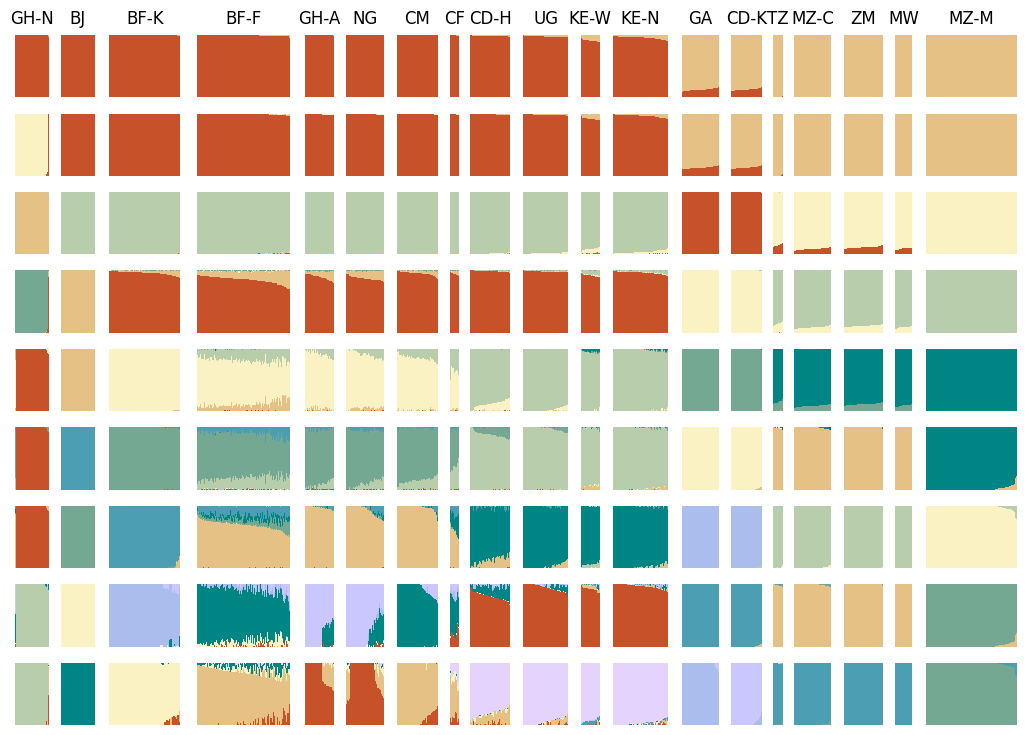

In [ ]:
fig = plot_admixture_svg(
    sample_sets = ['1.0', 'small-2023'],
    contig='2L',
    n_snps=50_000,
    thin_offset=1,
    min_minor_ac=17,
    max_missing_an=2,
    by='geographic_cohort_code',
    col_keys=['GH-N', 'BJ', 'BF-K', 'BF-F', 'GH-A', 'NG', 'CM', 'CF', 'CD-H', 'UG', 'KE-W', 'KE-N',
              'GA', 'CD-K', 'TZ', 'MZ-C', 'ZM', 'MW', 'MZ-M'],
    k_vals=list(range(2, 11)),
    seed=64000,
    colors=['#C7522A','#E5C185','#FBF2C4','#B8CDAB','#74A892',
            '#008585','#4C9EB3','#ABBDEC','#CAC7FF','#E4D3FC']
)
fig

In [ ]:
fig = plot_admixture(
    sample_sets = ['1.0', 'small-2023'],
    contig='2L',
    n_snps=50_000,
    thin_offset=0,
    min_minor_ac=17,
    max_missing_an=2,
    by='geographic_cohort_code',
    col_keys=['GH-N', 'BJ', 'BF-K', 'BF-F', 'GH-A', 'NG', 'CM', 'CF', 'CD-H', 'UG', 'KE-W', 'KE-N',
              'GA', 'CD-K', 'TZ', 'MZ-C', 'ZM', 'MW', 'MZ-M'],
    k_vals=list(range(2, 11)),
    seed=42,
    colors=['#C7522A','#E5C185','#FBF2C4','#B8CDAB','#74A892',
            '#008585','#4C9EB3','#ABBDEC','#CAC7FF','#E4D3FC']
)
fig

In [ ]:
fig = plot_admixture(
    sample_sets = ['1.0', 'small-2023'],
    contig='2L',
    n_snps=50_000,
    thin_offset=2,
    min_minor_ac=17,
    max_missing_an=2,
    by='geographic_cohort_code',
    col_keys=['GH-N', 'BJ', 'BF-K', 'BF-F', 'GH-A', 'NG', 'CM', 'CF', 'CD-H', 'UG', 'KE-W', 'KE-N',
              'GA', 'CD-K', 'TZ', 'MZ-C', 'ZM', 'MW', 'MZ-M'],
    k_vals=list(range(2, 11)),
    seed=2323,
    colors=['#C7522A','#E5C185','#FBF2C4','#B8CDAB','#74A892',
            '#008585','#4C9EB3','#ABBDEC','#CAC7FF','#E4D3FC']
)
fig

In [ ]:
def extract_cv_error(
    contig,
    n_snps,
    thin_offset,
    min_minor_ac,
    max_missing_an,
    k_vals=list(range(2, 7)),
    seed=42,
):
    plink_file_path = get_plink_file_path(
        contig=contig,
        n_snps=n_snps,
        thin_offset=thin_offset,
        min_minor_ac=min_minor_ac,
        max_missing_an=max_missing_an,
    )
    admixture_path = f"{plink_file_path}.admixture/{seed}"
    cv_error = []
    k_valid = []
    for k in k_vals:
        log_path = f"{admixture_path}/{k}.log"
        if os.path.exists(log_path):
          with open(log_path, mode="rt") as log_file:
              for line in log_file.readlines():
                  if line.startswith("CV error"):
                      e = float(line.split(":")[1])
                      cv_error.append(e)
                      k_valid.append(k)
    return pd.DataFrame({"contig": contig, "maf": min_minor_ac, "missing": max_missing_an,
                         "n_snps": n_snps, "seed": seed,
                         "thinning": thin_offset, "k": k_valid, "cv_error": cv_error})

In [ ]:
def plot_cv_error(df_cv_error):
  fig = px.violin(
      data_frame=df_cv_error,
      x="k",
      y="cv_error",
      color="k",
      color_discrete_sequence=['#C7522A','#E5C185','#FBF2C4','#B8CDAB','#74A892',
              '#008585','#4C9EB3','#ABBDEC','#CAC7FF','#E4D3FC'],
      points="all",
      labels={
          'k': 'K',
          'cv_error': "Cross-validation error",
      },
      width=600,
      height=400,
  )

  fig.update_xaxes(
      tickmode='array',
      tickvals=[2, 3, 4, 5, 6, 7, 8, 9, 10],
      linewidth=1, linecolor='black', showline=True
  )

  fig.update_yaxes(
      linewidth=1, linecolor='black', showline=True
  )

  fig.update_traces(
      pointpos=0,
  )

  fig.update_layout({
      'plot_bgcolor':'rgba(0,0,0,0)',
      'paper_bgcolor':'rgba(0,0,0,0)',
      'showlegend': False,
      'width': 800}
  )
  return fig



In [ ]:
df_k = df_cv_error.pivot(columns='k', values='cv_error', index=['seed', 'thinning'])

In [ ]:
plt.scatter?

In [ ]:
cdict = dict({2:'#C7522A',3:'#E5C185',4:'#FBF2C4',5:'#B8CDAB',6:'#74A892',
              7:'#008585',8:'#4C9EB3',9:'#ABBDEC',10:'#CAC7FF'})

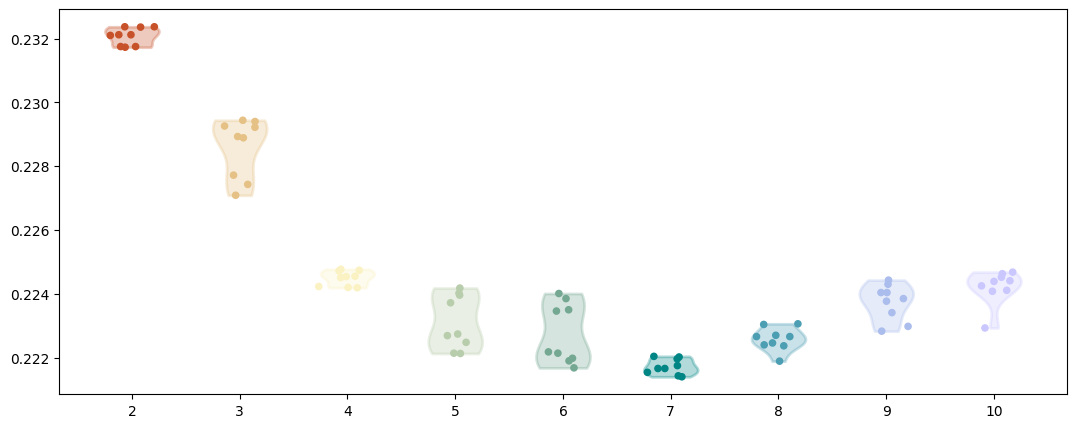

In [ ]:
fig,ax = plt.subplots(figsize=(13,5))
parts = ax.violinplot(df_k, positions=np.arange(2,11),
              showextrema=False)
for k, pc in zip(range(2,11), parts['bodies']):
    pc.set_facecolor(cdict[k])
    pc.set_edgecolor(cdict[k])
    pc.set_linewidth(2)
ax.scatter(df_cv_error.k+np.random.normal(0,.1, df_cv_error.shape[0]),
           df_cv_error.cv_error, s=20, c = df_cv_error.k.map(cdict))
ax.set_xticks(np.arange(2,11))
plt.show()

In [ ]:
import seaborn as sns

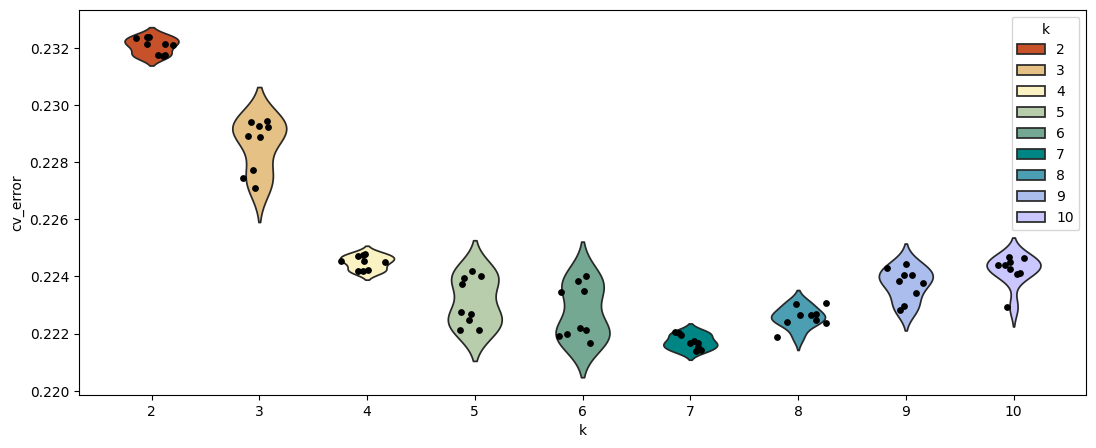

In [ ]:
fig, ax= plt.subplots(figsize=(13,5))
sns.violinplot(df_cv_error, x='k', y='cv_error', hue='k',
               palette=cdict, inner=None, width=.5,
               saturation=1,
               ax=ax)
ax.scatter(df_cv_error.k+np.random.normal(scale=.1, size=df_cv_error.shape[0]) -2,
                df_cv_error.cv_error, c='k',s=15)

plt.savefig(f'{results_dir}/kvalues.svg')

In [ ]:
np.random.normal?

In [ ]:
df_cv_error = pd.concat(
    [extract_cv_error(contig='2L', n_snps=n_snps, thin_offset=thin_offset, min_minor_ac=maf,
                      max_missing_an=missing, seed=seed, k_vals=list(range(2,11)))
     for n_snps in [50_000] for thin_offset in [0,1,2] for maf in [17]
     for missing in [2] for seed in [42,2323,64000]],
    axis=0,
    ignore_index=True,
)
plot_cv_error(df_cv_error)

In [ ]:
px.violin?

In [ ]:
df_cv_error = pd.concat(
    [extract_cv_error(contig='2L', n_snps=n_snps, thin_offset=thin_offset, min_minor_ac=maf,
                      max_missing_an=missing, seed=seed, k_vals=list(range(2,11)))
     for n_snps in [50_000, 100_000] for thin_offset in [0,1,2] for maf in [17]
     for missing in [17] for seed in [42,2323,64000]],
    axis=0,
    ignore_index=True,
)
plot_cv_error(df_cv_error)

In [ ]:
df_cv_error = pd.concat(
    [extract_cv_error(contig='2L', n_snps=n_snps, thin_offset=thin_offset, min_minor_ac=maf,
                      max_missing_an=missing, seed=seed, k_vals=list(range(2,11)))
     for n_snps in [50_000, 100_000] for thin_offset in [0,1,2] for maf in [84]
     for missing in [2,17] for seed in [42,2323,64000]],
    axis=0,
    ignore_index=True,
)
plot_cv_error(df_cv_error)

In [ ]:
df_cv_error = pd.concat(
    [extract_cv_error(contig='2L', n_snps=n_snps, thin_offset=thin_offset, min_minor_ac=maf,
                      max_missing_an=missing, seed=seed, k_vals=list(range(2,11)))
     for n_snps in [50_000, 100_000] for thin_offset in [0,1,2] for maf in [17]
     for missing in [2,17] for seed in [42,2323,64000]],
    axis=0,
    ignore_index=True,
)
plot_cv_error(df_cv_error)